# Load Toy dataset

In [1]:
import scipy.io
import numpy as np
from numpy import linalg as LA
import time
import matplotlib.pyplot as plt
%matplotlib inline
mat = scipy.io.loadmat('okl/data/synthdata.mat')

In [2]:
print('Shape of Ktrain:')
print(mat['Ktrain'].shape)
print('Shape of Kvalid:')
print(mat['Kvalid'].shape)

print('Shape of Ytrain:')
print(mat['Ytrain'].shape)
print('Shape of Yvalid:')
print(mat['Yvalid'].shape)

Shape of Ktrain:
(100, 100)
Shape of Kvalid:
(100, 100)
Shape of Ytrain:
(100, 200)
Shape of Yvalid:
(100, 200)


# OKL

In [3]:
def okl(K,Y,lam_list):
    
    """
    OKL with block coordinate descent
    
    model = okl(K,Y,lam_list)
    -------------------------------------------   
    Inputs:
        K: input kernel matrix: (l x l) matrix,
        Y: training outputs: (l x m) matrix.
        lam_list: list of regularization parameters.
        
    --------------------------------------------
    Output:
        model : output model containing the following information:
        L : output kernel
        C : coefficient matrix
        lambda : regularization parameter
        J : value of the objective functional
        time : execution time          
    """

    #constants
    l = K.shape[0]
    m = Y.shape[1]
    N = lam_list.shape[0]
    MAX_ITER = 1000
    TOL = 0.01
    delta = TOL * LA.norm(Y)

    # initialization 
    J = np.zeros((MAX_ITER,1))
    L = np.eye(m)
    C = np.zeros((l,m))

    # eigendecomposition of the input kernel matrix
    DX, UX = LA.eigh(K)
    '''
    For Symetric Real matrix :
    LA.eig -> complex space (due to computation issue)
    LA.eigh -> real space
    '''
    DX_ = DX.reshape((len(DX),1)) 
    dx = abs(DX_)
    '''
    The eigenvalues may be negative -> abs
    '''
    DX = np.diag(DX)
    Ytilde = np.dot(UX.T,Y)

    # MAIN loop
    model={}
    for k in range(N):
        start_time = time.time()
        lam = lam_list[k]
        print("lambda = "+str(lam))
        nit = 0
        res = LA.norm(Y)
    
        while(res > delta):
            # Sub-problem w.r.t. C.
            # Solve the Sylvester equation KCL+lambda*C = Y using eigendecomposition of K and L. 
            DY, UY = LA.eigh(L)
            DY_ = DY.reshape((len(DY),1))
            dy = abs(DY_)
            DY = np.diag(DY)
            Q = np.dot(Ytilde,UY)
            V = Q / (np.dot(dx,dy.T)+lam) #element wise division
            C = np.dot(np.dot(UX,V),UY.T)
        
            # Sub-problem w.r.t. L
            F = np.dot(V,UY.T)
            E = np.dot(DX,F)
            R = np.dot(E.T,E)
            DE, UE = LA.eigh(R)        
            DE_ = DE.reshape((len(DE),1))
            dep = abs(DE_)+lam
            DE = np.diag(DE)
        
            Lp = L
            temp = np.dot(R,L) + np.dot(L.T,R.T) + lam*np.dot(E.T,F)
            P = np.dot(np.dot(UE.T,temp),UE)
            temp = np.dot(dep,np.ones((1,m))) + np.dot(np.ones((m,1)),dep.T)
            L =np.dot(np.dot(UE, P/temp), UE.T)
        
            # Compute the value of the objective functional
            temp = F / 4 - Ytilde / (2*lam)
            J[nit] = LA.norm(Y)**2 / (2*lam) + np.trace(np.dot(np.dot(temp.T,E),L))
            #Compute the variation of L
            res = LA.norm(L-Lp)
        
            #Check whether the maximum number of iterations has been reached
            if nit >= MAX_ITER:
                print('Reached maximum number of iterations')
                break
            
            nit += 1
            modelk={}
            modelk['L']=L
            modelk['C']=C
            modelk['nit']=nit
            modelk['lambda']=lam
            modelk['J']=J[:nit]
            modelk['time']=time.time() - start_time
            model[k]=modelk
    return model

# Training

In [4]:
Ktrain = mat['Ktrain']
Ytrain = mat['Ytrain']
N = 30

######################why choose lam_list like this ?
lam_list = np.logspace(-5,0,N) * np.sqrt(LA.norm(np.dot(np.dot(Ytrain.T,Ktrain),Ytrain)))
lam_list = np.sort(lam_list)[::-1]

model = okl(Ktrain,Ytrain,lam_list)

lambda = 1031.82831001
lambda = 693.735064446
lambda = 466.422887388
lambda = 313.592783511
lambda = 210.839640441
lambda = 141.755028555
lambda = 95.3069739575
lambda = 64.0782861638
lambda = 43.0821228205
lambda = 28.9656515154
lambda = 19.4746431416
lambda = 13.0934988736
lambda = 8.80322743312
lambda = 5.9187245508
lambda = 3.97937013151
lambda = 2.67547281642
lambda = 1.7988160324
lambda = 1.20940833282
lambda = 0.813128462917
lambda = 0.54669533793
lambda = 0.367562822044
lambda = 0.247125626972
lambda = 0.166151394657
lambda = 0.111709523147
lambda = 0.0751063064346
lambda = 0.0504966551406
lambda = 0.0339507066907
lambda = 0.0228262739699
lambda = 0.0153469201125
lambda = 0.0103182831001


In [5]:
model[0]['L']

array([[ 0.00683449,  0.00407938,  0.00498564, ...,  0.00105408,
         0.00450809,  0.0033162 ],
       [ 0.00407938,  0.00422064,  0.00466445, ...,  0.00164804,
         0.00384093,  0.00296831],
       [ 0.00498564,  0.00466445,  0.011979  , ...,  0.00357094,
         0.00569083,  0.00579869],
       ..., 
       [ 0.00105408,  0.00164804,  0.00357094, ...,  0.00303124,
         0.00172028,  0.00241348],
       [ 0.00450809,  0.00384093,  0.00569083, ...,  0.00172028,
         0.00514177,  0.00361208],
       [ 0.0033162 ,  0.00296831,  0.00579869, ...,  0.00241348,
         0.00361208,  0.0042917 ]])

# Test

In [16]:
Kvalid = mat['Kvalid']
Yvalid = mat['Yvalid']
Ktest = mat['Ktest']
Y0 = mat['Y0']
def mse(Y,Y_pred):
    return np.mean((Y-Y_pred)**2)

### Identity baseline

In [17]:
#Identity baseline
IDVMSE= np.zeros((N,1))
IDMSE = np.zeros((N,1))
DX,UX = LA.eigh(Ktrain)
DX_ = DX.reshape((len(DX),1))
dx = abs(DX_)
DX = np.diag(DX)
l = Ktrain.shape[0]
m = Ytrain.shape[1]
for k in range(N):
    lam = lam_list[k]
    temp =  np.dot(dx,np.ones((1,m))) + lam
    C = np.dot(UX, np.dot(UX.T,Ytrain) / temp)
    IDVMSE[k] = mse(Yvalid,np.dot(Kvalid,C))
    IDMSE[k] = mse(Y0,np.dot(Ktest,C))
ii = np.argmin(IDVMSE)

In [18]:
print('For baseline method, when lambda = %.3f,\nvalidation MSE reaches the minimum = %.3f' %(lam_list[ii],IDVMSE[ii]))

For baseline method, when lambda = 0.813,
validation MSE reaches the minimum = 19.953


### OKL

In [21]:
def predict(K,C,L):
    return np.dot(np.dot(K,C),L)
OKLVMSE= np.zeros((N,1))
OKLMSE = np.zeros((N,1))
for k in range(N):
    OKLVMSE[k] = mse(Yvalid, predict(Kvalid,model[k]['C'],model[k]['L']))
    OKLMSE[k] =mse(Y0, predict(Ktest,model[k]['C'],model[k]['L']))
jj = np.argmin(OKLVMSE)

In [22]:
print('For OKL, when lambda = %.3f,\nvalidation MSE reaches the minimum = %.3f' %(lam_list[jj],OKLVMSE[jj]))

For OKL, when lambda = 13.093,
validation MSE reaches the minimum = 19.036


# Plot (model selection)

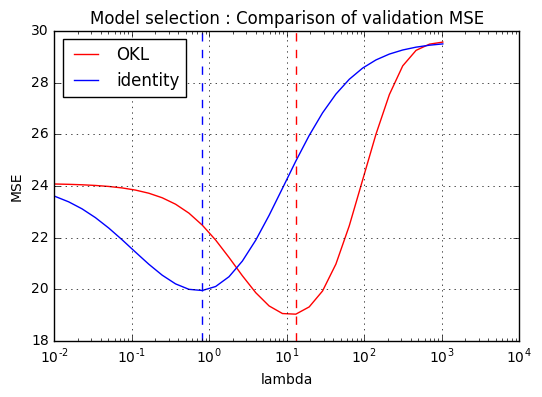

In [25]:
plt.semilogx(lam_list, OKLVMSE,label='OKL',color='red')
plt.semilogx(lam_list, IDVMSE,label='identity',color='blue')
plt.axvline(x=lam_list[jj],color='red',linestyle='--')
plt.axvline(x=lam_list[ii],color='blue',linestyle='--')
plt.title('Model selection : Comparison of validation MSE')
plt.grid(True)
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend(loc=0)


# Plot (test result)

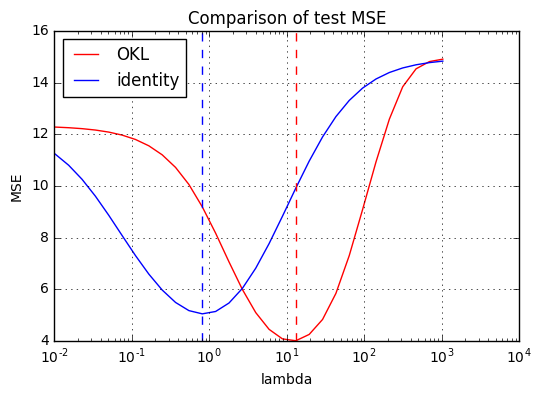

In [24]:
plt.semilogx(lam_list, OKLMSE,label='OKL',color='red')
plt.semilogx(lam_list, IDMSE,label='identity',color='blue')
plt.axvline(x=lam_list[jj],color='red',linestyle='--')
plt.axvline(x=lam_list[ii],color='blue',linestyle='--')
plt.title('Comparison of test MSE')
plt.grid(True)
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend(loc=0)
